# Neural Network approaches based on Spectrograms

In [2]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [3]:
import os
import time
import joblib
import librosa
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, Input, TimeDistributed, MaxPooling2D, Conv2D, AveragePooling2D, LSTM, BatchNormalization, Reshape, MaxPool1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotnine as p9
import seaborn as sns
from reusable.emotion_mapping import KerasWrapper, EmotionMap
import pickle

In [4]:
spectrogram_features = joblib.load('../dataset_processed/spectrogram_features.pkl')
mfcc_features = joblib.load('../dataset_processed/mfcc_features.pkl')
functional_features = joblib.load('../dataset_processed/functional_features.pkl')
aggregated_features = joblib.load('../dataset_processed/aggregated_features.pkl')

In [5]:
Y = functional_features['Emotion']
X = spectrogram_features

In [6]:
# print shapes of all X in a datafram
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,99
1,128,101
2,128,94
3,128,81
4,128,88


In [7]:
# add zeroes for second dimension to make all X of same shape
dim2max = df[1].max()
X = [np.pad(x, ((0, 0), (0, dim2max - x.shape[1])), mode='constant', constant_values=0) for x in X]
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,308
1,128,308
2,128,308
3,128,308
4,128,308


In [8]:
# crop each X to have siize 128x128
X = [x[:, :128] for x in X]
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,128
1,128,128
2,128,128
3,128,128
4,128,128


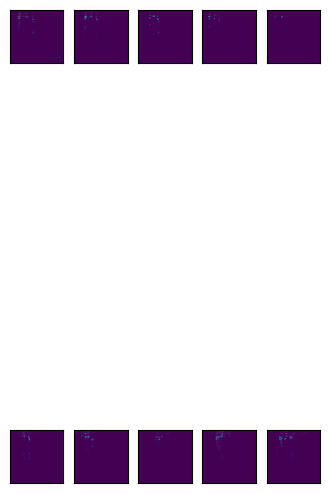

In [9]:
test_spectrograms = X[:10]
fig, axes = plt.subplots(2, 5, figsize=(4, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(test_spectrograms[i])

In [10]:
Y_names = np.unique(Y)
Y_names

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train[10].shape, X_test[10].shape)

(128, 128) (128, 128)


In [46]:
MODELS_PATH = r'..\models\emotion_mapping_spectogram'

# Plot results

In [25]:
def plot_results(model, history, X_test, Y_test, Y_names):
    try:
        y_pred  = model.predict(X_test)
        y_pred  = np.argmax(y_pred, axis=1)
        loss, accuracy = model.evaluate(X_test, EmotionMap.map_both(Y_test), verbose=0)
        print(f'Test Loss: {loss}')
        print(f'Test Mae: {accuracy}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure with 1 row and 2 columns

        # Plot on first axis
        ax1.plot(history.history['mae'], label='Training Mae')
        ax1.plot(history.history['val_mae'], label='Validation Mae')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend(loc='lower right')

        # Plot on second axis
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.loglog()
        ax2.legend(loc='lower right')
        # Optional: Adjust spacing between plots (optional)
        plt.tight_layout()

        plt.show()
    except Exception:
        print("Model did not converge")

# CNN approach

## Simple CNN model

In [13]:
def Simple_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1

In [26]:
Simple_CNN_1 = KerasWrapper(Simple_CNN())
Simple_CNN_1.compile(optimizer=SGD(lr=0.01, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Simple_CNN_1_history = Simple_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_6 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_6 (Dropout)         (None, 128, 64)           0         
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 57410 (224.26 KB)
Trainable params: 57410 (224.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/100
301/301 [==============================] - 5s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
301/301 [==============================] - 5s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
301/301 [==============================] - 6s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
301/301

#### Results

In [27]:
plot_results(Simple_CNN_1, Simple_CNN_1_history, X_test, Y_test, Y_names)

258/258 [==============================] - 1s 4ms/step
Test Loss: nan
Test Mae: nan
Model did not converge
Error in callback <function _draw_all_if_interactive at 0x000001D8E83CD090> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1500x500 with 2 Axes>

### Parameters 2

In [28]:
Simple_CNN_2 = KerasWrapper(Simple_CNN())
Simple_CNN_2.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Simple_CNN_history_2 = Simple_CNN_2.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_7 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_7 (Dropout)         (None, 128, 64)           0         
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 57410 (224.26 KB)
Trainable params: 57410 (224.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
301/301 [==============================] - 7s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
301/301 [==============================] - 6s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
301/301 [==============================] - 6s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
301/301

#### Results

In [29]:
plot_results(Simple_CNN_2, Simple_CNN_history_2, X_test, Y_test, Y_names)

258/258 [==============================] - 1s 4ms/step
Test Loss: nan
Test Mae: nan
Model did not converge
Error in callback <function _draw_all_if_interactive at 0x000001D8E83CD090> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1500x500 with 2 Axes>

### Parameters 3

In [30]:
Simple_CNN_3 = KerasWrapper(Simple_CNN())
Simple_CNN_3.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Simple_CNN_history_3 = Simple_CNN_3.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_8 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_8 (Dropout)         (None, 128, 64)           0         
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 57410 (224.26 KB)
Trainable params: 57410 (224.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/100
301/301 [==============================] - 8s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
301/301 [==============================] - 7s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
301/301

#### Results

In [31]:
plot_results(Simple_CNN_3, Simple_CNN_history_3, X_test, Y_test, Y_names)

258/258 [==============================] - 1s 4ms/step
Test Loss: nan
Test Mae: nan
Model did not converge
Error in callback <function _draw_all_if_interactive at 0x000001D8E83CD090> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1500x500 with 2 Axes>

## Simple CNN model small

In [32]:
def Simple_CNN_small() :
    model = Sequential()
    model.add(Conv1D(32, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1 

In [33]:
Simple_CNN_small_1 = KerasWrapper(Simple_CNN_small())
Simple_CNN_small_1.compile(optimizer=SGD(lr=0.005, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Simple_CNN_small_history_1 = Simple_CNN_small_1.fit(X_train, Y_train, batch_size=64, epochs=300, validation_data=(X_test, Y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 128, 32)           20512     
                                                                 
 activation_9 (Activation)   (None, 128, 32)           0         
                                                                 
 dropout_9 (Dropout)         (None, 128, 32)           0         
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 28706 (112.13 KB)
Trainable params: 28706 (112.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/300
301/301 [==============================] - 6s 19ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/300
301/301 [==============================] - 5s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/300
301/301 [==============================] - 5s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/300
301/301 [==============================] - 5s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/300
301/301 [==============================] - 5s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/300
301/301 [==============================] - 5s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/300
301/301 [==============================] - 5s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/300
301/301 [==============================] - 5s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/300
301/301

#### Results

In [34]:
plot_results(Simple_CNN_small_1, Simple_CNN_small_history_1, X_test, Y_test, Y_names)

258/258 [==============================] - 1s 4ms/step
Test Loss: nan
Test Mae: nan
Model did not converge
Error in callback <function _draw_all_if_interactive at 0x000001D8E83CD090> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1500x500 with 2 Axes>

## Double CNN

In [35]:
def Double_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1

In [36]:
Double_CNN_1 = KerasWrapper(Double_CNN())
Double_CNN_1.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Double_CNN_history_1 = Double_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 128, 64)           41024     
                                                                 
 batch_normalization (Batch  (None, 128, 64)           256       
 Normalization)                                                  
                                                                 
 activation_10 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_10 (Dropout)        (None, 128, 64)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 128, 64)           20544     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 64)           256       
 chNormalization)                                    

None
Epoch 1/100
301/301 [==============================] - 15s 41ms/step - loss: 3.0118 - mae: 0.6014 - val_loss: 0.3855 - val_mae: 0.4868
Epoch 2/100
301/301 [==============================] - 12s 40ms/step - loss: 0.3502 - mae: 0.4795 - val_loss: 0.3834 - val_mae: 0.4870
Epoch 3/100
301/301 [==============================] - 12s 39ms/step - loss: 0.3501 - mae: 0.4795 - val_loss: 0.3948 - val_mae: 0.4877
Epoch 4/100
301/301 [==============================] - 12s 39ms/step - loss: 0.4067 - mae: 0.4816 - val_loss: 0.4000 - val_mae: 0.5160
Epoch 5/100
301/301 [==============================] - 12s 39ms/step - loss: 0.3698 - mae: 0.4936 - val_loss: 0.3968 - val_mae: 0.4887
Epoch 6/100
301/301 [==============================] - 12s 39ms/step - loss: 0.3504 - mae: 0.4795 - val_loss: 0.4050 - val_mae: 0.4906
Epoch 7/100
301/301 [==============================] - 12s 39ms/step - loss: 0.3504 - mae: 0.4797 - val_loss: 0.3829 - val_mae: 0.4887
Epoch 8/100
301/301 [=============================

##### Results

258/258 [==============================] - 2s 6ms/step
Test Loss: 0.5217592120170593
Test Mae: 0.49608349800109863


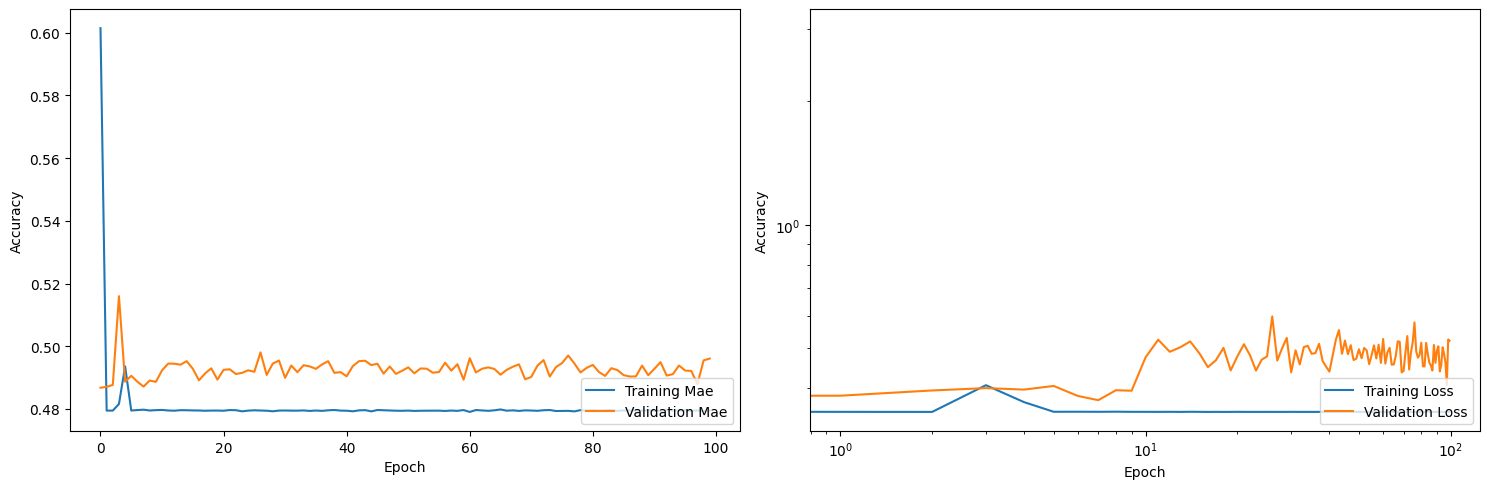

In [37]:
plot_results(Double_CNN_1, Double_CNN_history_1, X_test, Y_test, Y_names)

In [48]:
with open(rf"{MODELS_PATH}\Double_CNN_1.pkl", "wb") as output_file:
    pickle.dump(Double_CNN_1, output_file)

## Normalized CNN

In [38]:
def Normalized_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1

In [39]:
Normalized_CNN_1 = KerasWrapper(Normalized_CNN())
Normalized_CNN_1.compile(optimizer=SGD(lr=0.003, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
Normalized_CNN_history_1 = Normalized_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 128, 64)           41024     
                                                                 
 batch_normalization_2 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_12 (Dropout)        (None, 128, 64)           0         
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 16386     
                                                     

None
Epoch 1/100
301/301 [==============================] - 9s 27ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
301/301 [==============================] - 7s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
301/301 [==============================] - 7s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
301/301

#### Results

In [40]:
plot_results(Normalized_CNN_1, Normalized_CNN_history_1, X_test, Y_test, Y_names)

258/258 [==============================] - 1s 4ms/step
Test Loss: nan
Test Mae: nan
Model did not converge
Error in callback <function _draw_all_if_interactive at 0x000001D8E83CD090> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1500x500 with 2 Axes>

# CNN + LSTM approach

## Complex Model

In [41]:
def CNN_LSTM():
    model = Sequential(name='model2d')
    #LFLB1
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(Conv2D(filters=64,
                    kernel_size=3,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))
    #LFLB3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))

    #LFLB4
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))

    model.add(Reshape((-1, 128)))
    #LSTM
    model.add(LSTM(32))
    model.add(Dense(2))
    
    print(model.summary())
    return model

In [42]:
model_CNN_LSTM = KerasWrapper(CNN_LSTM())
model_CNN_LSTM.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error', metrics=['mae'])
history_CNN_LSTM = model_CNN_LSTM.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "model2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256 

None
Epoch 1/20
301/301 [==============================] - 329s 1s/step - loss: 0.3376 - mae: 0.4642 - val_loss: 0.3299 - val_mae: 0.4607
Epoch 2/20
301/301 [==============================] - 352s 1s/step - loss: 0.3060 - mae: 0.4366 - val_loss: 0.3080 - val_mae: 0.4448
Epoch 3/20
301/301 [==============================] - 337s 1s/step - loss: 0.2753 - mae: 0.4078 - val_loss: 0.2781 - val_mae: 0.4159
Epoch 4/20
301/301 [==============================] - 336s 1s/step - loss: 0.2586 - mae: 0.3906 - val_loss: 0.2662 - val_mae: 0.4062
Epoch 5/20
301/301 [==============================] - 342s 1s/step - loss: 0.2487 - mae: 0.3814 - val_loss: 0.2579 - val_mae: 0.3899
Epoch 6/20
301/301 [==============================] - 347s 1s/step - loss: 0.2400 - mae: 0.3721 - val_loss: 0.3180 - val_mae: 0.4106
Epoch 7/20
301/301 [==============================] - 347s 1s/step - loss: 0.2346 - mae: 0.3661 - val_loss: 0.2538 - val_mae: 0.3834
Epoch 8/20
301/301 [==============================] - 332s 1s/st

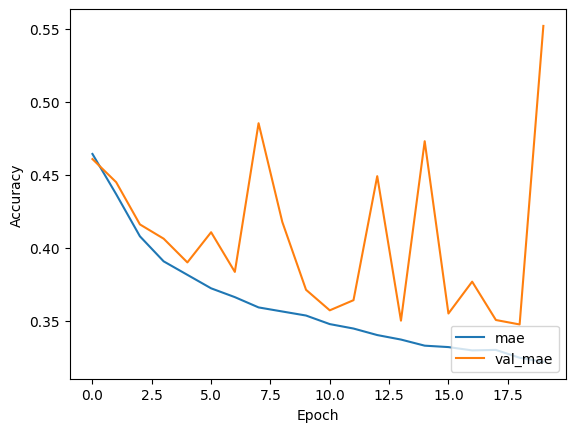

In [45]:
plt.plot(history_CNN_LSTM.history['mae'], label='mae')
plt.plot(history_CNN_LSTM.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [49]:
with open(rf"{MODELS_PATH}\model_CNN_LSTM.pkl", "wb") as output_file:
    pickle.dump(model_CNN_LSTM, output_file)

## Simple approach with MaxPooling

In [50]:
def CNN_LSTM_simple():
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    model.add(LSTM(32))
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1

In [51]:
model_CNN_LSTM_simple = KerasWrapper(CNN_LSTM_simple())
model_CNN_LSTM_simple.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error', metrics=['mae'])
history_CNN_LSTM_simple = model_CNN_LSTM_simple.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 128, 64)           41024     
                                                                 
 activation_17 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_13 (Dropout)        (None, 128, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 32, 64)            0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                     

None
Epoch 1/20
301/301 [==============================] - 8s 25ms/step - loss: 0.3448 - mae: 0.4726 - val_loss: 0.3454 - val_mae: 0.4714
Epoch 2/20
301/301 [==============================] - 7s 23ms/step - loss: 0.3371 - mae: 0.4614 - val_loss: 0.3401 - val_mae: 0.4644
Epoch 3/20
301/301 [==============================] - 7s 23ms/step - loss: 0.3321 - mae: 0.4562 - val_loss: 0.3358 - val_mae: 0.4609
Epoch 4/20
301/301 [==============================] - 6s 21ms/step - loss: 0.3280 - mae: 0.4527 - val_loss: 0.3326 - val_mae: 0.4585
Epoch 5/20
301/301 [==============================] - 6s 20ms/step - loss: 0.3251 - mae: 0.4503 - val_loss: 0.3303 - val_mae: 0.4580
Epoch 6/20
301/301 [==============================] - 6s 20ms/step - loss: 0.3231 - mae: 0.4492 - val_loss: 0.3296 - val_mae: 0.4579
Epoch 7/20
301/301 [==============================] - 6s 20ms/step - loss: 0.3216 - mae: 0.4482 - val_loss: 0.3267 - val_mae: 0.4542
Epoch 8/20
301/301 [==============================] - 6s 20ms/st

#### Results

258/258 [==============================] - 1s 4ms/step
Test Loss: 0.29773837327957153
Test Mae: 0.4193630516529083


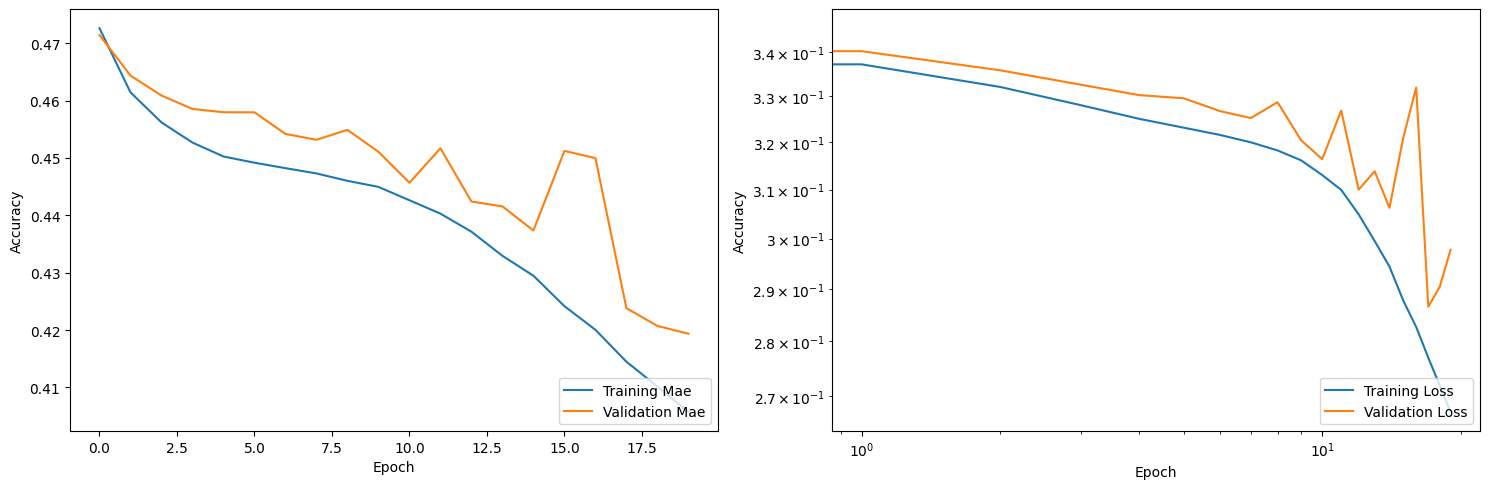

In [52]:
plot_results(model_CNN_LSTM_simple, history_CNN_LSTM_simple, X_test, Y_test, Y_names)

In [56]:
with open(rf"{MODELS_PATH}\CNN_LSTM_simple.pkl", "wb") as output_file:
    pickle.dump(CNN_LSTM_simple, output_file)

## Simple approach no MaxPooling

In [53]:
def CNN_LSTM_simple_nopool():
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(16))
    model.add(Dense(2))
    print(model.summary())
    return model

### Parameters 1

In [54]:
simple_CNN_LSTM_no_pool = KerasWrapper(CNN_LSTM_simple_nopool())
simple_CNN_LSTM_no_pool.compile(optimizer=SGD(lr=0.05, momentum=0.8), loss='mean_squared_error', metrics=['mae'])
history_simple_CNN_LSTM_no_pool = simple_CNN_LSTM_no_pool.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 128, 64)           41024     
                                                                 
 activation_18 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_14 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
Total params: 46242 (180.63 KB)
Trainable params: 46242 (180.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/20
301/301 [==============================] - 12s 38ms/step - loss: 0.3504 - mae: 0.4797 - val_loss: 0.3543 - val_mae: 0.4843
Epoch 2/20
301/301 [==============================] - 9s 31ms/step - loss: 0.3501 - mae: 0.4791 - val_loss: 0.3527 - val_mae: 0.4823
Epoch 3/20
301/301 [==============================] - 9s 31ms/step - loss: 0.3497 - mae: 0.4786 - val_loss: 0.3527 - val_mae: 0.4826
Epoch 4/20
301/301 [==============================] - 9s 31ms/step - loss: 0.3495 - mae: 0.4783 - val_loss: 0.3524 - val_mae: 0.4810
Epoch 5/20
301/301 [==============================] - 9s 30ms/step - loss: 0.3496 - mae: 0.4781 - val_loss: 0.3520 - val_mae: 0.4825
Epoch 6/20
301/301 [==============================] - 9s 30ms/step - loss: 0.3491 - mae: 0.4777 - val_loss: 0.3519 - val_mae: 0.4831
Epoch 7/20
301/301 [==============================] - 9s 30ms/step - loss: 0.3489 - mae: 0.4772 - val_loss: 0.3511 - val_mae: 0.4804
Epoch 8/20
301/301 [==============================] - 9s 30ms/s

#### Results

258/258 [==============================] - 2s 7ms/step
Test Loss: 0.31848183274269104
Test Mae: 0.44680288434028625


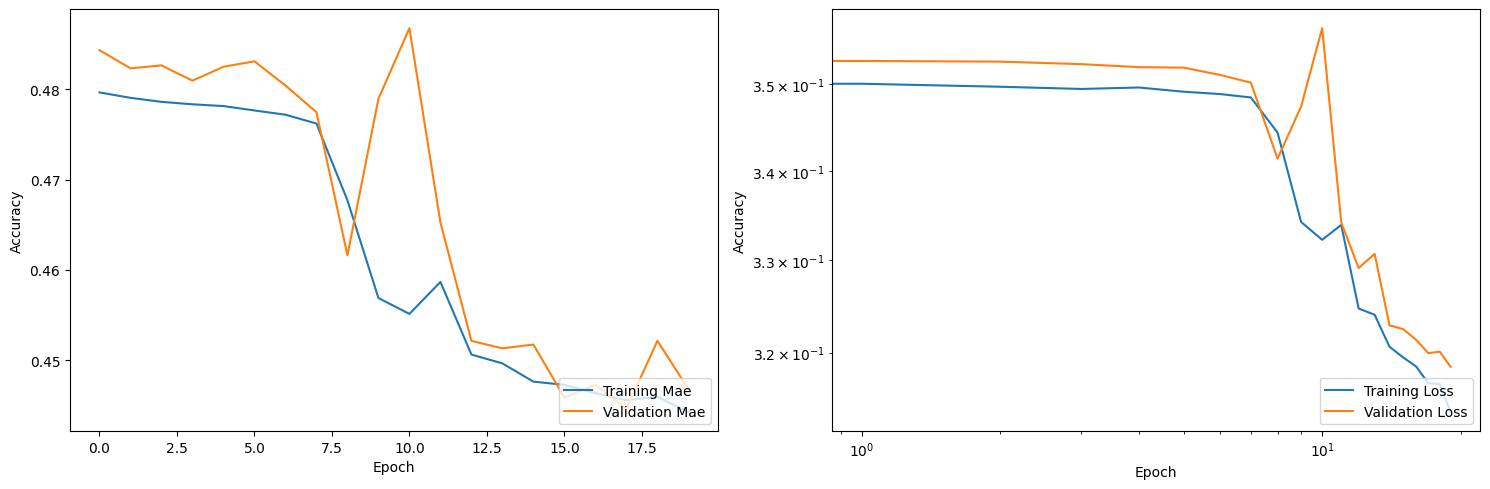

In [55]:
plot_results(simple_CNN_LSTM_no_pool, history_simple_CNN_LSTM_no_pool, X_test, Y_test, Y_names)

In [57]:
with open(rf"{MODELS_PATH}\simple_CNN_LSTM_no_pool.pkl", "wb") as output_file:
    pickle.dump(simple_CNN_LSTM_no_pool, output_file)